In [2]:
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

model, preprocess = clip.load("ViT-B/16")

In [3]:
from RefcocogDataset import RefcocogDataset
from torch.utils.data import DataLoader

train_dataset = RefcocogDataset("./refcocog", split="train", transform=preprocess)
val_dataset = RefcocogDataset("./refcocog", split="val", transform=preprocess)
test_dataset = RefcocogDataset("./refcocog", split="test", transform=preprocess)

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

80512 4896 9602


In [4]:
def visualize(sample, bbox, idx=0):
    print(f"Sentence: {sample['sentences'][idx]}")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(sample['image'][idx].permute(1, 2, 0))
    axes[1].imshow(bbox['gt'][idx])
    plt.tight_layout()
    plt.show()

def build_probability_map(patch_tokens, out_text):
    patch_tokens = patch_tokens.squeeze(0)[1:]
    map = torch.zeros(196)

    for i, token in enumerate(patch_tokens):
        map[i] = 1 - torch.cosine_similarity(token, out_text).item() # 1 - ... temporary fix
    
    map = torch.sigmoid(map)
    map = map.reshape(14, 14)
    return map


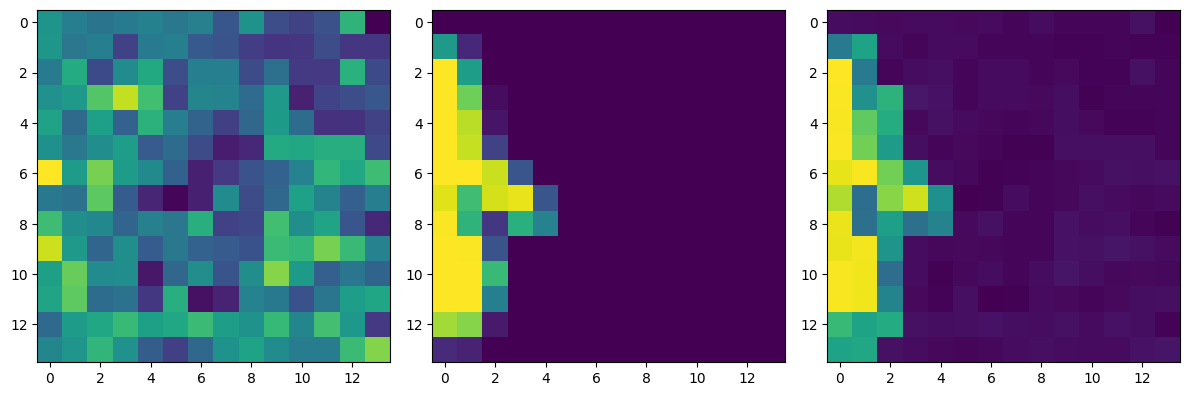

In [11]:
def loss(map, gt, gamma=1):
    map = map.reshape(-1)
    gt = gt.reshape(-1)
    abs = torch.abs(map - gt)
    log = -torch.log(1-abs)
    
    # amplify the error of pixel that should belong to the object, according to strenght of label
    log = torch.where(gt == 0, log, torch.pow(log+1, gamma)*(gt+1))

    loss = torch.sum(log)
    return loss, log

for sample, bbox in train_loader:
    idx = 1

    out_image, out_text, patch_tokens, text_tokens = model.encode(sample['image'][idx].unsqueeze(0), clip.tokenize(sample['sentences'][idx]))
    out_image, out_text = patch_tokens[0, 0].unsqueeze(0), text_tokens[0, -1].unsqueeze(0)
    
    # print(f'Similarity: {torch.cosine_similarity(out_image, out_text).item():.4f}')
    
    map = build_probability_map(patch_tokens, out_text)
    gt = bbox['gt'][idx]/255

    loss, log = loss(map, gt, gamma=1) # keep gamma = 1 for now



    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(map)
    axs[1].imshow(bbox['gt'][idx])
    axs[2].imshow(log.reshape(14, 14))
    plt.tight_layout()
    plt.show()
    break